### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("2411.18892")

'Published: 2025-02-01\nTitle: A Comprehensive Survey of Reinforcement Learning: From Algorithms to Practical Challenges\nAuthors: Majid Ghasemi, Amir Hossein Moosavi, Dariush Ebrahimi\nSummary: Reinforcement Learning (RL) has emerged as a powerful paradigm in Artificial Intelligence (AI), enabling agents to learn optimal behaviors through interactions with their environments. Drawing from the foundations of trial and error, RL equips agents to make informed decisions through feedback in the form of'

In [23]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wikipedia=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wikipedia.name

'wikipedia'

In [24]:
wikipedia.invoke("What did Stephen Hawking found out ?")

'Page: Stephen Hawking\nSummary: Stephen William Hawking (8 January 1942 – 14 March 2018) was an English theoretical astrophysicist, cosmologist, and author who was director of research at the Centre for Theoretical Cosmology at the University of Cambridge. Between 1979 and 2009, he was the Lucasian Professor of Mathematics at Cambridge, widely viewed as one of the most prestigious academic posts in the world.\nHawking was born in Oxford into a family of physicians. In October 1959, at the age of 1'

In [25]:

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"



In [7]:
key = os.getenv("TAVILY_API_KEY")
if key is not None:
    os.environ["TAVILY_API_KEY"] = key
else:
    raise ValueError("TAVILY_API_KEY is not set")


In [8]:
# Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/qt/64kxbqr16ps6hbrf1lzxq5dc0000gn/T/ipykernel_14101/3336424662.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [10]:
tavily.invoke("Provide me the recent AI news for feb 2nd 2026")

[{'title': 'AI News Briefs BULLETIN BOARD for February 2026',
  'url': 'https://radicaldatascience.wordpress.com/2026/02/02/ai-news-briefs-bulletin-board-for-february-2026/',
  'content': 'Welcome to the AI News Briefs Bulletin Board, a timely new channel bringing you the latest industry insights and perspectives surrounding the field of AI including deep learning, large language models, generative AI, and transformers. I am working tirelessly to dig up the most timely and curious tidbits underlying the day’s most popular technologies. I know this field is advancing rapidly and I want to bring you a regular resource to keep you informed and state-of-the-art. The news bites are constantly being added in reverse date order (most recent on top). With the bulletin board you can check back often to see what’s happening in our rapidly accelerating industry. Click HERE to check out previous “AI News Briefs” round-ups. [...] What Anthropic evaluates:\n\nWhat the results show:\n\n[1/30/2026] Ho

In [26]:
# Combine all the tools in the list
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b
tools=[arxiv,wikipedia,tavily,add,multiply,divide]

In [27]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama-3.3-70b-versatile")
llm_with_tools = llm.bind_tools(tools)

In [28]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gbt4crnj0', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 744, 'total_tokens': 764, 'completion_time': 0.066749345, 'completion_tokens_details': None, 'prompt_time': 0.073477633, 'prompt_tokens_details': None, 'queue_time': 0.053773095, 'total_time': 0.140226978}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c06d5113ec', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c24ba-3995-71f0-920b-e1578a5770d7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'gbt4crnj0', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 744, 'output_tokens': 20, 'total_tokens': 764})

In [14]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'scbyhggm4',
  'type': 'tool_call'}]

In [29]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

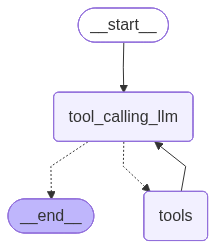

In [30]:
# Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (mh6e8yeng)
 Call ID: mh6e8yeng
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base
================================== Ai Message ==================================
Tool Calls:
  wikipedia (j925cfbgz)
 Call ID: j925cfbgz
  Args:
    

In [18]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for February 2nd 2026,add 69 and 69 and then multipy it by 62")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for February 2nd 2026,add 69 and 69 and then multipy it by 62
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (mtt9a9hj0)
 Call ID: mtt9a9hj0
  Args:
    query: top 10 recent AI news February 2nd 2026
  add (b2c44nhf1)
 Call ID: b2c44nhf1
  Args:
    a: 69
    b: 69
  multiply (1063ksna2)
 Call ID: 1063ksna2
  Args:
    a: 138
    b: 62
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News Briefs BULLETIN BOARD for February 2026", "url": "https://radicaldatascience.wordpress.com/2026/02/02/ai-news-briefs-bulletin-board-for-february-2026/", "content": "Welcome to the AI News Briefs Bulletin Board, a timely new channel bringing you the latest industry insights and perspectives surrounding the field of AI including deep

In [31]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

BadRequestError: Error code: 400 - {'error': {'message': 'tool call validation failed: attempted to call tool \'wikipedia{"query": "Machine learning"}\' which was not in request.tools', 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=wikipedia{"query": "Machine learning"}></function>'}}